## Flexible foliar stoichiometry reduces the magnitude of the land C sink

This notebook documents how to download and analyze data used for the manuscript "Flexible foliar stoichiometry reduces the magnitude of the land C sink." This notebook accesses data from the Community Land Model, CMIP6, and the Global Carbon Project. These data are used to make a set of figures also detalied below. 

#### Load Packages

In [1]:
#Load necessary packages for data visualization 
import xarray as xr
from ctsm_py import utils
#import utils
import numpy as np
import pandas as pd
from netCDF4 import num2date
import dask 
from scipy import stats

#some resources for plotting
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os,sys
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

%matplotlib inline
import datetime as dt
from datetime import datetime

import seaborn as sns
import math as mt
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point

#### Read in Data

In [2]:
### Data for future simulations
# User defined options
model = 'CLM5_GSWP3'
## Read in slope 0 and slope 20 cases
archive = '/glade/scratch/wwieder/archive/'
caseShort = ['cnSlope0', 'cnSlope20', 'cnMulti']
cases = ['ctsm51d074_2deg_GSWP3V1_ssp370_'+short for short in caseShort]
path = '/lnd/hist/'
fin = [archive + case + path + "concat/" + case + '_cat_short.nc' for case in cases]
#print(fin[0])

# Read in files for .area and .landfrac
fin2 = [archive + case + path + case + '.clm2.h0.2015-01.nc' for case in cases]
#print(fin2[0])

### Read in historical data
cases2 = ['ctsm51d074_2deg_GSWP3V1_hist_'+short for short in caseShort]
finHist = [archive + case + path + "concat/" + case + '_cat_short.nc' for case in cases2]

# Read in files for .area and .landfrac
finHist2 = [archive + case + path + case + '.clm2.h0.1850-01.nc' for case in cases2]
print(finHist2[0])

/glade/scratch/wwieder/archive/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0/lnd/hist/ctsm51d074_2deg_GSWP3V1_hist_cnSlope0.clm2.h0.1850-01.nc


In [3]:
# Read in data, time and time_bounds just used for utils.time_set_mid
var = ['NPP', 'GPP', 'LEAFCN', 'QVEGT','QVEGE', 'QSOIL','TOTVEGC', 'ELAI', 'TOTLITC','TOTLITN', 'QRUNOFF_TO_COUPLER', 'ER', 'HR','NBP', 'NET_NMIN','NFIX','FPI','RAIN', 'SNOW',
       'time', 'time_bounds']

'''select the variables we want to read in'''
def preprocess(ds, var=var):
    return ds[var]

# For slope 0
for i in range(len(cases)):
    dsIN = utils.time_set_mid(xr.open_mfdataset(fin[i], decode_times=True, preprocess = preprocess), 'time')
    LandDs = utils.time_set_mid(xr.open_mfdataset(fin2[i], decode_times=True), 'time')
    dsIN['area'] = LandDs.area
    dsIN['landfrac'] = LandDs.landfrac

    if i == 0:
        ds = dsIN
    else:
        ds = xr.concat([ds,dsIN],"case",data_vars='all')


ds = ds.assign_coords(case=("case", caseShort))
ds = ds[['NPP', 'GPP', 'LEAFCN', 'QVEGT','QVEGE', 'QSOIL','TOTVEGC', 'ELAI', 'FPI','TOTLITC','TOTLITN', 'QRUNOFF_TO_COUPLER', 'ER', 'HR','NBP', 'NET_NMIN','NFIX','RAIN', 'SNOW']]
#ds = ds.load()  # this may make things really slow now, but hopefully faster later on
ds

<xarray.Dataset>
Dimensions:             (case: 3, time: 1032, lat: 96, lon: 144)
Coordinates:
  * time                (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:0...
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                 (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * case                (case) <U9 'cnSlope0' 'cnSlope20' 'cnMulti'
Data variables: (12/19)
    NPP                 (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    GPP                 (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    LEAFCN              (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    QVEGT               (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    QVEGE               (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    QSOIL               (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    ...                  ...
    HR                  (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    NBP                 (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    NET_NMIN            (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    NFIX                (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    RAIN                (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
    SNOW                (case, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 96, 144), meta=np.ndarray>
Attributes: (12/100)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Mon Aug 22 16:02:29 2022: ncrcat -v...
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    NCO:                                  netCDF Operators version 5.0.3 (Hom...

In [4]:
## Read in historical data

'''select the variables we want to read in'''
def preprocess(ds2, var=var):
    return ds2[var]

# For slope 0
for i in range(len(cases)):
    dsIN2 = utils.time_set_mid(xr.open_mfdataset(finHist[i], decode_times=True, preprocess = preprocess), 'time')
    LandDs2 = utils.time_set_mid(xr.open_mfdataset(finHist2[i], decode_times=True), 'time')
    dsIN2['area'] = LandDs2.area
    dsIN2['landfrac'] = LandDs2.landfrac

    if i == 0:
        ds2 = dsIN2
    else:
        ds2 = xr.concat([ds2,dsIN2],"case",data_vars='all')


ds2 = ds2.assign_coords(case=("case", caseShort))
ds2 = ds2[['NPP', 'GPP', 'LEAFCN', 'QVEGT','QVEGE', 'QSOIL','TOTVEGC', 'ELAI', 'FPI','TOTLITC','TOTLITN', 'QRUNOFF_TO_COUPLER', 'ER', 'HR','NBP', 'NET_NMIN','NFIX', 'RAIN', 'SNOW']]
#ds = ds.load()  # this may make things really slow now, but hopefully faster later on
ds2

<xarray.Dataset>
Dimensions:             (case: 3, time: 1980, lat: 96, lon: 144)
Coordinates:
  * time                (time) object 1850-01-16 11:44:59.999993 ... 2014-12-...
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                 (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * case                (case) <U9 'cnSlope0' 'cnSlope20' 'cnMulti'
Data variables: (12/19)
    NPP                 (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    GPP                 (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    LEAFCN              (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    QVEGT               (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    QVEGE               (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    QSOIL               (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    ...                  ...
    HR                  (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NBP                 (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NET_NMIN            (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NFIX                (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    RAIN                (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    SNOW                (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
Attributes: (12/100)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Mon Aug 22 16:16:56 2022: ncrcat -v...
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    NCO:                                  netCDF Operators version 5.0.3 (Hom...

In [5]:
##Combine the historical and future data into one dataset and option to load to memory 
dsFull = xr.concat([ds2,ds],"time",data_vars='all')
#dsFull.load() 
dsFull

<xarray.Dataset>
Dimensions:             (case: 3, time: 3012, lat: 96, lon: 144)
Coordinates:
  * time                (time) object 1850-01-16 11:44:59.999993 ... 2100-12-...
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                 (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * case                (case) <U9 'cnSlope0' 'cnSlope20' 'cnMulti'
Data variables: (12/19)
    NPP                 (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    GPP                 (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    LEAFCN              (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    QVEGT               (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    QVEGE               (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    QSOIL               (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    ...                  ...
    HR                  (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NBP                 (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NET_NMIN            (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    NFIX                (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    RAIN                (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
    SNOW                (case, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 96, 144), meta=np.ndarray>
Attributes: (12/100)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Mon Aug 22 16:16:56 2022: ncrcat -v...
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    NCO:                                  netCDF Operators version 5.0.3 (Hom...

### Convert monthly to annual

In [6]:
spy = 365 * 24 * 3600               # Convert  to annual fluxes (gC/m2/y), from gc/m2/s 
dsAnn = dsFull.apply(utils.weighted_annual_mean)
fluxes = ['GPP', 'NPP', 'NFIX', 'NET_NMIN', 'ER', 'HR', 'QVEGT', 'QVEGE','QSOIL','NBP', 'RAIN','SNOW', 'QRUNOFF_TO_COUPLER']
for i in range(len(fluxes)):
    dsAnn[fluxes[i]] = dsAnn[fluxes[i]] * spy

In [7]:
##Load to memory
dsAnn = dsAnn.load()
print('loaded data to memory')

loaded data to memory


In [8]:
## Mask out really small values
minGPP2 = 10
dsAnn = dsAnn.where(dsAnn.GPP.min('time') > minGPP2)
dsFull = dsFull.where(dsFull.GPP.min('time') > minGPP2)

### Calculate Litter C:N

In [9]:
dsAnn['LITCN'] = dsAnn.TOTLITC / dsAnn.TOTLITN
dsAnn['LITCN'].attrs['units'] = 'gC/gN'

### Calculate ET

In [10]:
dsAnn['ET'] = dsAnn.QVEGT + dsAnn.QVEGE + dsAnn.QSOIL
dsAnn['ET'].attrs['units'] = 'mm y^-1'
minET = 10
dsAnn = dsAnn.where(dsAnn.ET.min('time') > minET)

### Calculate WUE

In [11]:
dsAnn['WUE'] = dsAnn.GPP / dsAnn.ET

### Calculate water yield

In [12]:
dsAnn['WaterYield'] = dsAnn.QRUNOFF_TO_COUPLER / (dsAnn.RAIN + dsAnn.SNOW)

### Calculate N Min/ NPP

In [13]:
dsAnn['NMin_NPP'] = dsAnn.NET_NMIN/dsAnn.NPP

### Add units back into metadata

In [14]:
AllVars = ['NPP', 'GPP', 'LEAFCN', 'QVEGT','QVEGE', 'QSOIL','FPI','TOTVEGC', 'ELAI', 'TOTLITC','TOTLITN', 'QRUNOFF_TO_COUPLER', 'ER', 'HR','NBP', 'NET_NMIN','NFIX']
CVars = ['NPP', 'GPP','NBP','ER', 'HR']
NVars = ['NFIX', 'NET_NMIN']
WaterVars = ['ET', 'QRUNOFF_TO_COUPLER', 'WaterYield']
WUE = ['WUE']
for i in range(len(AllVars)):
    dsAnn.attrs[AllVars[i]] = dsFull.get(AllVars[i]).attrs
for i in range(len(CVars)): 
    dsAnn[CVars[i]].attrs['units'] = 'gC/m2/yr'
for i in range(len(NVars)): 
    dsAnn[NVars[i]].attrs['units'] = 'gN/m2/yr'
for i in range(len(WaterVars)): 
    dsAnn[WaterVars[i]].attrs['units'] = 'mm/yr'
for i in range(len(WUE)): 
    dsAnn[WUE[i]].attrs['units'] = 'gC/mm'

### Make weights for global sum

sum area_wgt = 0.9999999


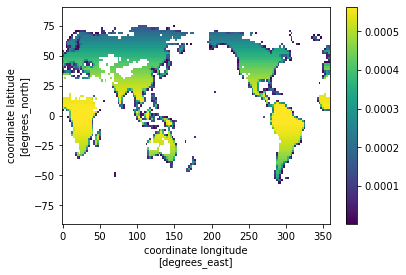

In [15]:
# only weight areas for grids with GPP>0
minGPP = 10.
landUp = LandDs.area * LandDs.landfrac * 1e6      # area in km2, not m2
landUp = landUp.where(dsAnn.GPP.isel(case=0).min('time') > minGPP)
landUp.attrs['units'] = 'm^2'

# weighting for each grid cell
area_wgt = (landUp / landUp.sum()).drop('case')
area_wgt.plot()
print('sum area_wgt = '+ str(area_wgt.sum().values) )

### Calculate the global sums

In [16]:
# ?? This could also be done regionally (see Paul's comments on google doc) ??
ann_glob = (dsAnn * landUp).sum(dim=('lat', 'lon'))

## 1 mm water = 1 kg/m2,  1e-15 for kg to Tt,  1e-15 gC to PgC,
# convert to Pg C/y, mm to Tt
Cvars = ['TOTVEGC','GPP','NPP', 'NBP', 'HR', 'ER']
Nvars = ['NFIX', 'NET_NMIN']
Water = ['ET', 'QRUNOFF_TO_COUPLER', 'WaterYield']
CNvars = ['LITCN','LEAFCN', 'FPI', 'NMin_NPP']
for i in range(len(Cvars)):
    ann_glob[Cvars[i]] = ann_glob[Cvars[i]] * 1e-15
    if Cvars[i] == 'TOTVEGC':
        
        ann_glob[Cvars[i]].attrs['units'] = 'Pg C'
    else: 
        ann_glob[Cvars[i]].attrs['units'] = 'Pg C y^-1'
         
for i in range(len(Nvars)):
    ann_glob[Nvars[i]] = ann_glob[Nvars[i]] * 1e-12
    ann_glob[Nvars[i]].attrs['units'] = 'Tg N y^-1'
        
##Add metadata
for i in range(len(Cvars)):
    ann_glob.attrs[Cvars[i]] = ann_glob.get(Cvars[i]).attrs
for i in range(len(Nvars)):
    ann_glob.attrs[Nvars[i]] = ann_glob.get(Nvars[i]).attrs


# area weighted mean
ann_Awgt = (dsAnn * area_wgt).sum(dim=('lat', 'lon'))

##Add metadata
for i in range(len(Cvars)):
    ann_Awgt.attrs[Cvars[i]] = ann_glob.get(Cvars[i]).attrs
    ann_Awgt[Cvars[i]].attrs['units'] = 'Pg C y^-1'
for i in range(len(Nvars)):
    ann_Awgt.attrs[Nvars[i]] = ann_glob.get(Nvars[i]).attrs
    ann_Awgt[Nvars[i]].attrs['units'] = 'TgN y^-1'
for i in range(len(CNvars)):
    ann_Awgt.attrs[CNvars[i]] = dsAnn.get(CNvars[i]).attrs
for i in range(len(Water)):
    ann_Awgt.attrs[Water[i]] = dsAnn.get(Water[i]).attrs
    ann_Awgt[Water[i]].attrs['units'] = 'mm y^-1'
ann_Awgt['WUE'].attrs['units'] = 'gC/mm'

### Subset cases to use, list varible sets

In [17]:
#quick plot , the `;` on the last line supresses text after executing the cell
vars = ['GPP', 'NPP', 'TOTVEGC', 'CUE', 'EFLX_LH_TOT', 'LEAFCN']
globVars = ['GPP', 'NPP', 'NBP', 'TOTVEGC', 'NFIX', 'NET_NMIN']
vars2 = ['EFLX_LH_TOT', 'LEAFCN', 'LITCN']

ann_glob_sub = ann_glob.isel(case = [0,1])
ann_glob_sub.attrs = ann_glob.attrs
ann_Awgt_sub = ann_Awgt.isel(case = [0,1])
ann_Awgt_sub.attrs = ann_Awgt.attrs

## Start making manuscript figures here

### Figure 1, NBP, cumulative land C uptake

#### Import GCP and CMIP Datasets

In [18]:
#First organize NBP data
# Cumulative annual flux over time   
cNBP = {}
cNBP['NBP'] = ann_glob['NBP'].cumsum(dim='time').load()
##Make NBP part of ann_glob dataframe
dsAnn['cumNBP'] = dsAnn['NBP'].cumsum(dim='time').load()
dsAnn['cumNBP'].attrs['units'] = 'gC/m2'

In [19]:
## Read in GCP data
gcp = pd.read_csv('GCP_2016.csv')

In [22]:
## Set up confidence intervals for plot
UC = 0.8
landHigh = gcp.Land - gcp.LULCC + UC
landLow = gcp.Land - gcp.LULCC - UC
land = gcp.Land- gcp.LULCC
cum_Land = land.cumsum()
cum_LandH = landHigh.cumsum()
cum_LandL =  landLow.cumsum()

In [23]:
##Set years of interest to trim CLM data
from datetime import date

start = date(1960, 1, 1) 
end = date(2016, 1, 1)

year_range = [year for year in range(start.year, end.year +1)]

start2 = date(1960, 1, 1) 
end2 = date(2099, 1, 1)

year_range2 = [year for year in range(start2.year, end2.year +1)]

In [24]:
## Read in CMIP data
cmip = '/glade/scratch/wwieder/CMIP6_annual_nbp.nc'
CMIP6 = xr.open_mfdataset(cmip, decode_times=True)

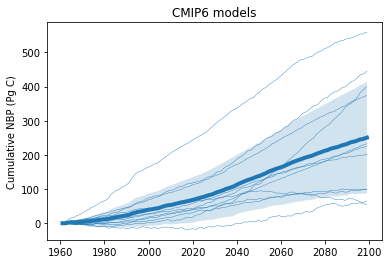

In [25]:
CMIP6_short = CMIP6.sel(year=slice('1960-12-16','2099-12-16'))

models = ['ACCESS-ESM1-5','CanESM5','CESM2',
          'CMCC-CM2-SR5','CNRM-ESM2-1','GFDL-ESM4',
          #'GISS-E2-1-H', SSP data from GISS are not correct
          'INM-CM5-0','IPSL-CM6A-LR','MIROC-ES2L',
          'MPI-ESM1-2-LR','UKESM1-0-LL',
         ]

x = CMIP6_short.year
y = CMIP6_short.nbp.cumsum(dim='year').mean('model')
y2 = CMIP6_short.nbp.cumsum(dim='year').std('model')
plt.plot(x,y,linewidth=4)
plt.fill_between(x,y+y2,y-y2, alpha=0.2) 
for m in range(len(models)):
    plt.plot(x,CMIP6_short.nbp.isel(model=m).cumsum(dim='year').values,
             linewidth=0.4, color='tab:blue')
plt.ylabel('Cumulative NBP (Pg C)')
plt.title('CMIP6 models')  ;

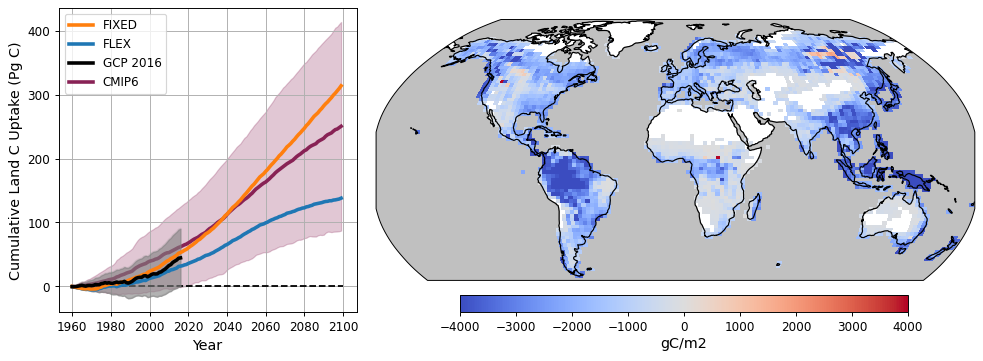

In [26]:
##### Make the plot #####

proj = ccrs.Robinson(central_longitude=0)
dsAnn = dsAnn.where(dsAnn.GPP.min('time') > minGPP)
z = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['cumNBP']# Climatology for last 10 years of data
zMulti = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['cumNBP']
zdiff = zMulti - z
zdiff = utils.cyclic_dataarray(zdiff)
lat = zdiff.coords['lat']
lon = zdiff.coords['lon']

fig = plt.figure(figsize=(15, 5), dpi=86)
spec = fig.add_gridspec(16, 60)

ax2 = fig.add_subplot(spec[0:, 24:], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Difference in land C uptake between Fixed and Flex by 2100')
im = zdiff.plot(x='lon', y='lat',
                  vmin=-4000, vmax=4000,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)

cax = fig.add_subplot(spec[-1:,29:56])
cb1 = fig.colorbar(im, cax=cax, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax.set_title("gC/m2", y=-2.5, fontsize = 12)
cax.xaxis.set_ticks_position('bottom')


ax1 = fig.add_subplot(spec[1:16, 5:23])
ax1.grid(zorder = 0)
ax1.hlines(0,1960, 2100, color = 'black', linestyles = 'dashed')
control = cNBP['NBP'].sel(time = slice('1960-12-16','2100-11-16'), case = 'cnSlope0').values + (93.3203492)
cnMulti = cNBP['NBP'].sel(time = slice('1960-12-16','2100-11-16'), case = 'cnSlope20').values + (93.92729433)
ax1.plot(year_range2,control, linewidth = 3, label = 'FIXED', color = "#ff7f0e", zorder = 5)
ax1.plot(year_range2,cnMulti, linewidth = 3, label = "FLEX", color = "#1f77b4", zorder = 4)
ax1.plot(year_range,cum_Land, linewidth = 3, label = "GCP 2016", color = "black", zorder = 6)
ax1.plot(year_range,cum_LandH, color = 'grey', alpha = 0.2, zorder = 3)
ax1.plot(year_range,cum_LandL, color = 'grey',alpha = 0.2, zorder = 3)
ax1.fill_between(year_range, cum_LandH,cum_LandL, color='grey', zorder = 3, alpha = 0.6)
ax1.plot(x,y,linewidth=3, color = '#882255', label = "CMIP6", zorder =2)
ax1.fill_between(x,y+y2,y-y2, alpha=0.25, color = '#882255', zorder = 1) 

#ax1.set_title('Cumulative Land Uptake')
ax1.set_ylabel('Cumulative Land C Uptake (Pg C)', fontsize = 12);
ax1.set_xlabel('Year', fontsize =12)
ax1.legend();


## Figure 2, C cycling plots , NPP, HR

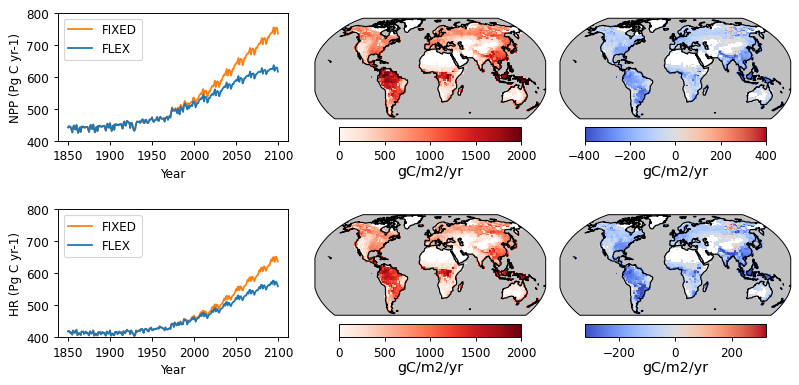

In [27]:
proj = ccrs.Robinson(central_longitude=0)
z = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['NPP']# Climatology for last 10 years of data
zMulti = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['NPP']
zdiff = zMulti - z
zdiff = utils.cyclic_dataarray(zdiff)
lat = zdiff.coords['lat']
lon = zdiff.coords['lon']

fig = plt.figure(figsize=(11, 5), dpi=86)
spec = fig.add_gridspec(20, 60)

ax2 = fig.add_subplot(spec[0:7, 21:40], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('NPP 2100')
im = z.plot(x='lon', y='lat',
                  vmin=0, vmax=2000,
                  cmap='Reds',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax = fig.add_subplot(spec[7:8,23:38])
cb1 = fig.colorbar(im, cax=cax, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax.set_title("gC/m2/yr", y=-3, fontsize = 12)
cax.xaxis.set_ticks_position('bottom')

ax3 = fig.add_subplot(spec[0:7, 41:60], projection=proj)
ax3.add_feature(cfeature.OCEAN, facecolor='silver')
ax3.coastlines()
ax3.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax3.set_title('Difference between Fixed and Flex in 2100')
im = zdiff.plot(x='lon', y='lat',
                  vmin=-400, vmax=400,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax2 = fig.add_subplot(spec[7:8,43:58])
cb2 = fig.colorbar(im, cax=cax2, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax2.set_title("gC/m2/yr", y=-3, fontsize = 12)
cax2.xaxis.set_ticks_position('bottom')


ax1 = fig.add_subplot(spec[0:8, :19])
NPP1 = ann_Awgt.isel(case = 1)
NPP1.attrs['NPP'] = ann_glob.get('NPP').attrs
NPP0 = ann_Awgt.isel(case = 0)
NPP0.attrs['NPP'] = ann_glob.get('NPP').attrs

ax1.plot(ann_Awgt_sub.coords['time.year'], NPP0.get('NPP'), label = "FIXED", color = "#ff7f0e");
ax1.plot(ann_Awgt_sub.coords['time.year'], NPP1.get('NPP'), label = "FLEX", color = "#1f77b4");
ax1.set_xlabel('Year')
ax1.set_ylabel('NPP (Pg C yr-1)')
ax1.set_title('');
ax1.legend(loc='upper left');
ax1.set_ylim(400,800)

###############Start HR Set 
z2 = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['HR']# Climatology for last 10 years of data
zMulti2 = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['HR']
zdiff2 = zMulti2 - z2
zdiff2 = utils.cyclic_dataarray(zdiff)


ax2 = fig.add_subplot(spec[12:19, 21:40], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('HR 2100')
im = z2.plot(x='lon', y='lat',
                  vmin=0, vmax=2000,
                  cmap='Reds',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax3 = fig.add_subplot(spec[-1:,23:38])
cb3 = fig.colorbar(im, cax=cax3, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax3.set_title("gC/m2/yr", y=-3, fontsize = 12)
cax3.xaxis.set_ticks_position('bottom')

ax3 = fig.add_subplot(spec[12:19, 41:60], projection=proj)
ax3.add_feature(cfeature.OCEAN, facecolor='silver')
ax3.coastlines()
ax3.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax3.set_title('Difference between Fixed and Flex in 2100')
im = zdiff2.plot(x='lon', y='lat',
                  #vmin=-400, vmax=400,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax3 = fig.add_subplot(spec[-1:,43:58])
cb3 = fig.colorbar(im, cax=cax3, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax3.set_title("gC/m2/yr", y=-3, fontsize = 12)
cax3.xaxis.set_ticks_position('bottom')

ax1 = fig.add_subplot(spec[12:20, :19])
NPP1 = ann_Awgt.isel(case = 1)
NPP1.attrs['NPP'] = ann_glob.get('NPP').attrs
NPP0 = ann_Awgt.isel(case = 0)
NPP0.attrs['NPP'] = ann_glob.get('NPP').attrs

ax1.plot(ann_Awgt_sub.coords['time.year'], NPP0.get('HR'), label = "FIXED", color = '#ff7f0e');
ax1.plot(ann_Awgt_sub.coords['time.year'], NPP1.get('HR'), label = "FLEX", color = '#1f77b4' );
ax1.set_xlabel('Year')
ax1.set_ylabel('HR (Pg C yr-1)')
ax1.set_title('');
ax1.legend(loc='upper left');
ax1.set_ylim(400,800);

## Figure 3, Hydrologic cycling, runoff and ET

In [31]:
ann_lat = dsAnn.mean(dim=('lon'))
futureCont = ann_lat.isel(case = [0], time=slice(-10,None)).mean('time').squeeze('case')
presentCont = ann_lat.isel(case = [0], time=slice(165,175)).mean('time').squeeze('case')

future20 = ann_lat.isel(case = [1], time=slice(-10,None)).mean('time').squeeze('case')
present20 = ann_lat.isel(case = [1], time=slice(165,175)).mean('time').squeeze('case')

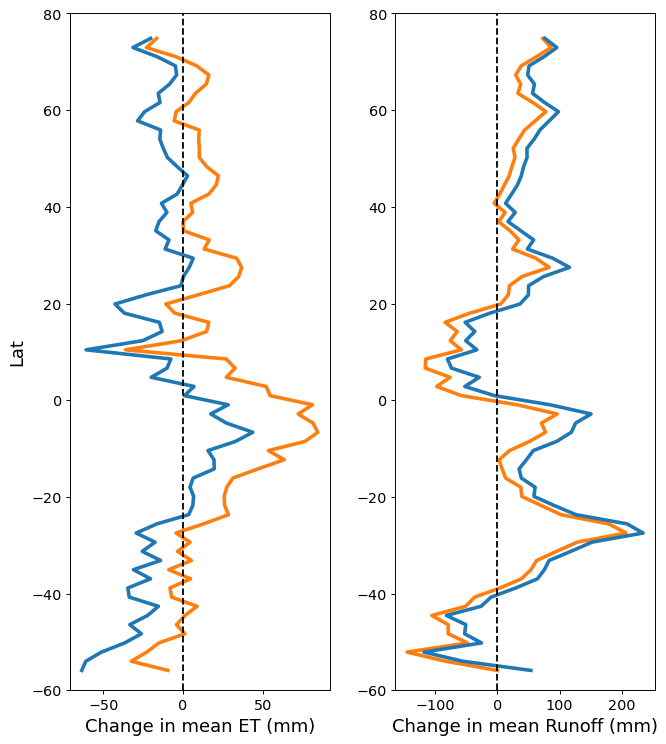

In [32]:
fig = plt.figure(figsize=(20, 15), dpi=86)
spec = fig.add_gridspec(10, 410)

ax1 = fig.add_subplot(spec[3:, :80])
ax1.plot(futureCont.get('ET')-presentCont.get('ET'), futureCont.get('lat'), color = '#ff7f0e', linewidth = 3);
ax1.plot(future20.get('ET')-present20.get('ET'), future20.get('lat'), color = '#1f77b4', linewidth = 3);
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel('Change in mean ET (mm)', size = 15)
ax1.set_ylabel('Lat', size = 15);
ax1.set_ylim(-60,80 )
ax1.axvline(0,color = 'black',linestyle = 'dashed')
    
ax3 = fig.add_subplot(spec[3:, 100:180])
ax3.plot(futureCont.get('QRUNOFF_TO_COUPLER') - presentCont.get('QRUNOFF_TO_COUPLER'), futureCont.get('lat'), color = '#ff7f0e', linewidth = 3);
ax3.plot(future20.get('QRUNOFF_TO_COUPLER') -present20.get('QRUNOFF_TO_COUPLER'), future20.get('lat'), color = '#1f77b4', linewidth = 3);
ax3.set_xlabel('Change in mean Runoff (mm)', size = 15)
ax3.tick_params(axis='both', which='major', labelsize=12)
#ax2.set_xlim(0,1250)
ax3.axvline(0,color = 'black',linestyle = 'dashed')
ax3.set_ylim(-60,80)
ax3.set_ylabel('');


## Extended data figures start here

#### Extended Data Figure 1; plot of changes to foliar C:N implemented in new parameterization and changes to litter C:N

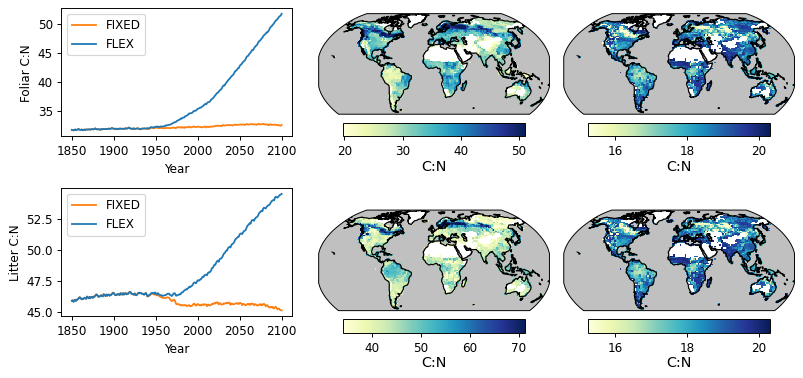

In [40]:
proj = ccrs.Robinson(central_longitude=0)
z = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['LEAFCN']# Climatology for last 10 years of data
zMulti = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['LEAFCN']
zdiff = zMulti - z
zdiff = utils.cyclic_dataarray(zdiff)
lat = zdiff.coords['lat']
lon = zdiff.coords['lon']

fig = plt.figure(figsize=(11, 5), dpi=86)
spec = fig.add_gridspec(20, 60)

ax2 = fig.add_subplot(spec[0:7, 21:40], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Foliar C:N 2100')
im = z.plot(x='lon', y='lat',
                  #vmin=0, vmax=2000,
                  cmap='YlGnBu',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax = fig.add_subplot(spec[7:8,23:38])
cb1 = fig.colorbar(im, cax=cax, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax.set_title("C:N", y=-3, fontsize = 12)
cax.xaxis.set_ticks_position('bottom')

ax3 = fig.add_subplot(spec[0:7, 41:60], projection=proj)
ax3.add_feature(cfeature.OCEAN, facecolor='silver')
ax3.coastlines()
ax3.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax3.set_title('Difference between Fixed and Flex in 2100')
im = zdiff.plot(x='lon', y='lat',
                  #vmin=-400, vmax=400,
                  cmap='YlGnBu',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax2 = fig.add_subplot(spec[7:8,43:58])
cb2 = fig.colorbar(im, cax=cax2, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax2.set_title("C:N", y=-3, fontsize = 12)
cax2.xaxis.set_ticks_position('bottom')


ax1 = fig.add_subplot(spec[0:8, :19])
LEAF1 = ann_Awgt.isel(case = 1)
LEAF1.attrs['LEAFCN'] = ann_glob.get('LEAFCN').attrs
LEAF0 = ann_Awgt.isel(case = 0)
LEAF0.attrs['LEAFCN'] = ann_glob.get('LEAFCN').attrs

ax1.plot(ann_Awgt_sub.coords['time.year'], LEAF0.get('LEAFCN'), label = "FIXED", color = '#ff7f0e');
ax1.plot(ann_Awgt_sub.coords['time.year'], LEAF1.get('LEAFCN'), label = "FLEX", color = '#1f77b4');
ax1.set_xlabel('Year')
ax1.set_ylabel('Foliar C:N')
ax1.set_title('');
ax1.legend(loc='upper left');
#ax1.set_ylim(400,800)

###############Start HR Set 
z2 = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['LITCN']# Climatology for last 10 years of data
zMulti2 = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['LITCN']
zdiff2 = zMulti2 - z2
zdiff2 = utils.cyclic_dataarray(zdiff)


ax2 = fig.add_subplot(spec[12:19, 21:40], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Litter C:N 2100')
im = z2.plot(x='lon', y='lat',
                  #vmin=0, vmax=2000,
                  cmap='YlGnBu',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax3 = fig.add_subplot(spec[-1:,23:38])
cb3 = fig.colorbar(im, cax=cax3, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax3.set_title("C:N", y=-3, fontsize = 12)
cax3.xaxis.set_ticks_position('bottom')

ax3 = fig.add_subplot(spec[12:19, 41:60], projection=proj)
ax3.add_feature(cfeature.OCEAN, facecolor='silver')
ax3.coastlines()
ax3.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax3.set_title('Difference between Fixed and Flex in 2100')
im = zdiff2.plot(x='lon', y='lat',
                  #vmin=-400, vmax=400,
                  cmap='YlGnBu',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax3 = fig.add_subplot(spec[-1:,43:58])
cb3 = fig.colorbar(im, cax=cax3, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax3.set_title("C:N", y=-3, fontsize = 12)
cax3.xaxis.set_ticks_position('bottom')

ax1 = fig.add_subplot(spec[11:19, :19])
LITTER1 = ann_Awgt.isel(case = 1)
LITTER1.attrs['LITCN'] = ann_glob.get('LITCN').attrs
LITTER0 = ann_Awgt.isel(case = 0)
LITTER0.attrs['LITCN'] = ann_glob.get('LITCN').attrs

ax1.plot(ann_Awgt_sub.coords['time.year'], LITTER0.get('LITCN'), label = "FIXED", color = '#ff7f0e');
ax1.plot(ann_Awgt_sub.coords['time.year'], LITTER1.get('LITCN'), label = "FLEX", color = '#1f77b4');
ax1.set_xlabel('Year')
ax1.set_ylabel('Litter C:N')
ax1.set_title('');
ax1.legend(loc='upper left');
#ax1.set_ylim(400,800);

#### Extended Data Figure 2; Annual NBP and maps of cumulative land C uptake at end of the simulations for FIXED and FLEX

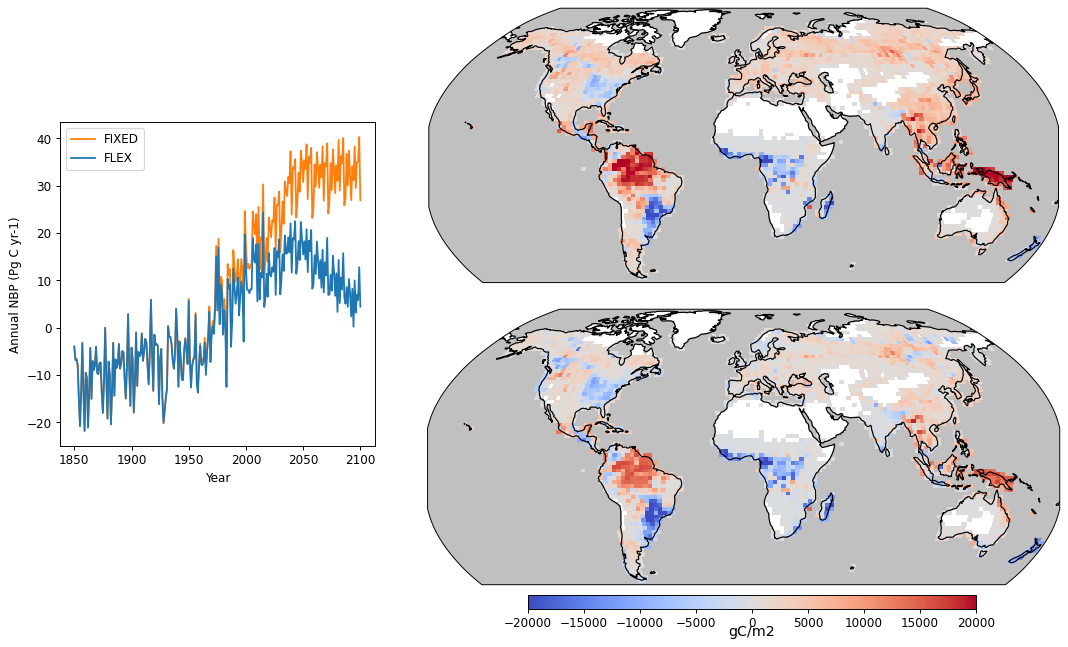

In [35]:
proj = ccrs.Robinson(central_longitude=0)
zx = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['cumNBP']# Climatology for last 10 years of data
lat = zdiff.coords['lat']
lon = zdiff.coords['lon']

fig = plt.figure(figsize=(15, 10), dpi=86)
spec = fig.add_gridspec(40, 60)


ax2 = fig.add_subplot(spec[3:20, 22:60], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Cumulative NBP in Fixed, 2100')
im = zx.plot(x='lon', y='lat',
                  vmin=-20000, vmax=20000,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)


minGPP = 1
dsAnn = dsAnn.where(dsAnn.GPP.min('time') > minGPP)
NBP1 = ann_Awgt.isel(case = 1)
NBP1.attrs['NBP'] = ann_glob.get('NBP').attrs
NBP0 = ann_Awgt.isel(case = 0)
NBP0.attrs['NBP'] = ann_glob.get('NBP').attrs
ax1 = fig.add_subplot(spec[10:30, :19])
ax1.plot(ann_Awgt_sub.coords['time.year'], NBP0.get('NBP'), label = "FIXED", color = "#ff7f0e" );
ax1.plot(ann_Awgt_sub.coords['time.year'], NBP1.get('NBP'), label = "FLEX", color = "#1f77b4");
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual NBP (Pg C yr-1)')
#ax1.set_title('Average Annual NBP');
ax1.legend(loc='upper left');

##Add a 3rd plot

zy = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['cumNBP']# Climatology for last 10 years of data


ax3 = fig.add_subplot(spec[21:39, 22:60], projection=proj)
ax3.add_feature(cfeature.OCEAN, facecolor='silver')
ax3.coastlines()
ax3.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Cumulative NBP in Fixed, 2100')
im2 = zy.plot(x='lon', y='lat',
                  #vmin=-4000, vmax=4000,
                  cmap='coolwarm',
                  vmin = -20000,
                  vmax = 20000,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)

cax2 = fig.add_subplot(spec[-1:,28:55])
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal")#, vmin = -15000, vmax = 15000)#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax2.set_title("gC/m2", y=-2.5, fontsize = 12)
cax2.xaxis.set_ticks_position('bottom')



#### Extended Data Figure 3, GPP plots

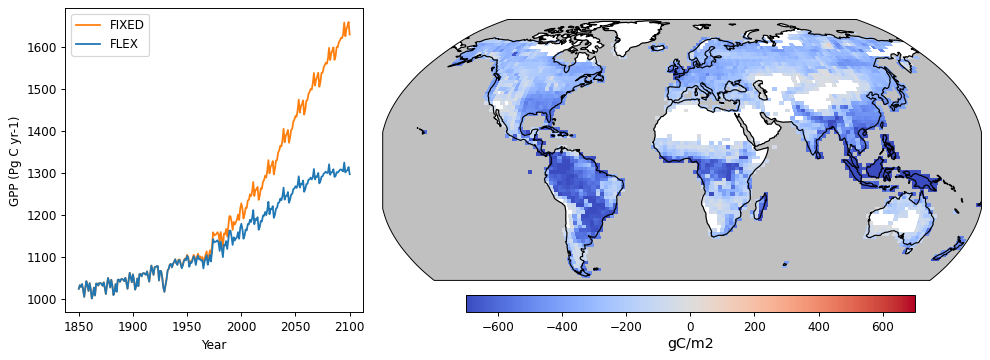

In [47]:
proj = ccrs.Robinson(central_longitude=0)
z = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['GPP']# Climatology for last 10 years of data
zMulti = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['GPP']
zdiff = zMulti - z
zdiff = utils.cyclic_dataarray(zdiff)
lat = zdiff.coords['lat']
lon = zdiff.coords['lon']

fig = plt.figure(figsize=(15, 5), dpi=86)
spec = fig.add_gridspec(16, 60)

ax2 = fig.add_subplot(spec[0:, 24:], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Cumulative NBP in Fixed, 2100')
im = zdiff.plot(x='lon', y='lat',
                  vmin=-700, vmax=700,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)

cax = fig.add_subplot(spec[-1:,29:56])
cb1 = fig.colorbar(im, cax=cax, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax.set_title("gC/m2", y=-2.5, fontsize = 12)
cax.xaxis.set_ticks_position('bottom')

minGPP = 1
dsAnn = dsAnn.where(dsAnn.GPP.min('time') > minGPP)
NBP1 = ann_Awgt.isel(case = 1)
NBP1.attrs['GPP'] = ann_glob.get('GPP').attrs
NBP0 = ann_Awgt.isel(case = 0)
NBP0.attrs['GPP'] = ann_glob.get('GPP').attrs
ax1 = fig.add_subplot(spec[1:16, 5:23])
ax1.plot(ann_Awgt_sub.coords['time.year'], NBP0.get('GPP'), label = "FIXED", color = "#ff7f0e" );
ax1.plot(ann_Awgt_sub.coords['time.year'], NBP1.get('GPP'), label = "FLEX", color = "#1f77b4");
ax1.set_xlabel('Year')
ax1.set_ylabel('GPP (Pg C yr-1)')
ax1.legend(loc='upper left');


#### Extended Data Figure 4, ELAI plot for max annual ELAI

/glade/work/ehauser/opt/miniconda/envs/analysis/lib/python3.10/site-packages/dask/array/reductions.py:540: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/glade/work/ehauser/opt/miniconda/envs/analysis/lib/python3.10/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/glade/work/ehauser/opt/miniconda/envs/analysis/lib/python3.10/site-packages/dask/array/reductions.py:540: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/glade/work/ehauser/opt/miniconda/envs/analysis/lib/python3.10/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/glade/work/ehauser/opt/miniconda/envs/analysis/lib/python3.10/site-packages/dask/array/reductions.py:540: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_ch

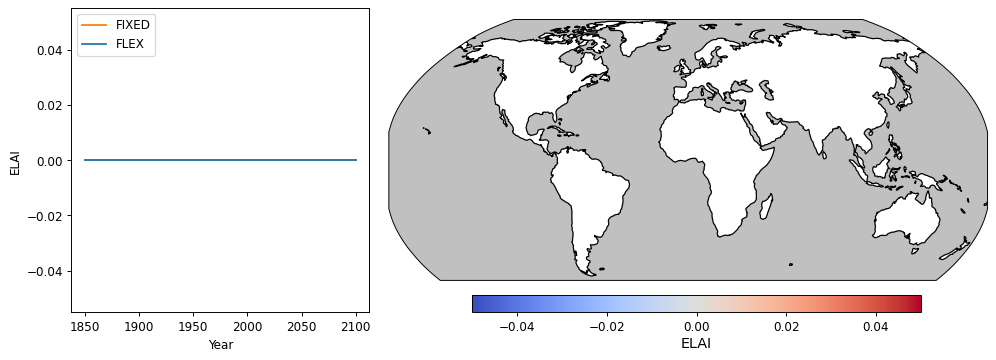

In [48]:
#Create subset for max ELAI
maxLAI = dsFull.ELAI.groupby('time.year').max()
ann_LAI = (maxLAI * area_wgt).sum(dim=('lat', 'lon'))

proj = ccrs.Robinson(central_longitude=0)
z = maxLAI.isel(case=0,year=slice(-10,None)).mean('year')
zdiff = maxLAI.isel(case=1,year=slice(-10,None)).mean('year')
z3 = zdiff - z# Climatology for last 10 years of data
lat = zdiff.coords['lat']
lon = zdiff.coords['lon']

##Make the plot
fig = plt.figure(figsize=(15, 5), dpi=86)
spec = fig.add_gridspec(16, 60)

ax2 = fig.add_subplot(spec[0:, 24:], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Change in ELAI 2100')
im = z3.plot(x='lon', y='lat',
                  #vmin=-4000, vmax=4000,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)

cax = fig.add_subplot(spec[-1:,29:56])
cb1 = fig.colorbar(im, cax=cax, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax.set_title("ELAI", y=-2.5, fontsize = 12)
cax.xaxis.set_ticks_position('bottom')

ELAI1 = ann_LAI.isel(case = 1)
ELAI0 = ann_LAI.isel(case = 0)
ax1 = fig.add_subplot(spec[1:16, 5:23])
ax1.plot(ann_Awgt_sub.coords['time.year'], ELAI0.values, label = "FIXED", color = "#ff7f0e" );
ax1.plot(ann_Awgt_sub.coords['time.year'], ELAI1.values, label = "FLEX", color = "#1f77b4");
ax1.set_xlabel('Year')
ax1.set_ylabel('ELAI')
ax1.legend(loc='upper left');

#### Extended Data Figure 5, Hydrologic data, ET and Runoff plots 

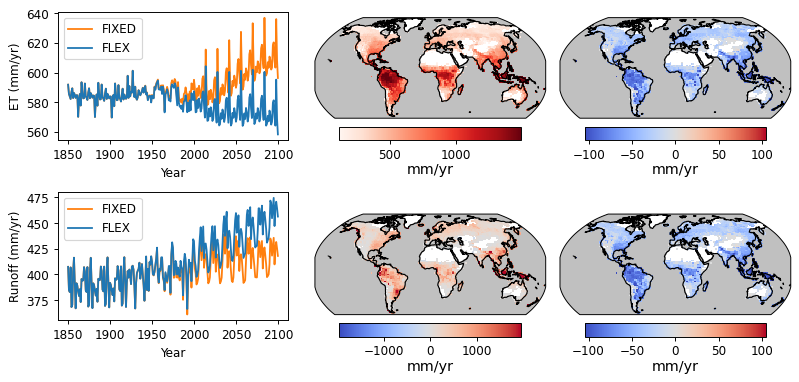

In [52]:
proj = ccrs.Robinson(central_longitude=0)
z = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['ET']# Climatology for last 10 years of data
zMulti = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['ET']
zdiff = zMulti - z
zdiff = utils.cyclic_dataarray(zdiff)
lat = zdiff.coords['lat']
lon = zdiff.coords['lon']

fig = plt.figure(figsize=(11, 5), dpi=86)
spec = fig.add_gridspec(20, 60)

ax2 = fig.add_subplot(spec[0:7, 21:40], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('ET 2100')
im = z.plot(x='lon', y='lat',
                  #vmin=0, vmax=2000,
                  cmap='Reds',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax = fig.add_subplot(spec[7:8,23:38])
cb1 = fig.colorbar(im, cax=cax, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax.set_title("mm/yr", y=-3, fontsize = 12)
cax.xaxis.set_ticks_position('bottom')

ax3 = fig.add_subplot(spec[0:7, 41:60], projection=proj)
ax3.add_feature(cfeature.OCEAN, facecolor='silver')
ax3.coastlines()
ax3.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax3.set_title('Difference between Fixed and Flex in 2100')
im = zdiff.plot(x='lon', y='lat',
                  #vmin=-400, vmax=400,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax2 = fig.add_subplot(spec[7:8,43:58])
cb2 = fig.colorbar(im, cax=cax2, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax2.set_title("mm/yr", y=-3, fontsize = 12)
cax2.xaxis.set_ticks_position('bottom')


ax1 = fig.add_subplot(spec[0:8, :19])
ET1 = ann_Awgt.isel(case = 1)
ET1.attrs['ET'] = ann_glob.get('ET').attrs
ET0 = ann_Awgt.isel(case = 0)
ET0.attrs['ET'] = ann_glob.get('ET').attrs

ax1.plot(ann_Awgt_sub.coords['time.year'], ET0.get('ET'), label = "FIXED", color ='#ff7f0e');
ax1.plot(ann_Awgt_sub.coords['time.year'], ET1.get('ET'), label = "FLEX", color = '#1f77b4');
ax1.set_xlabel('Year')
ax1.set_ylabel('ET (mm/yr)')
ax1.set_title('');
ax1.legend(loc='upper left');
#ax1.set_ylim(400,800)

###############Start HR Set 
z2 = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['QRUNOFF_TO_COUPLER']# Climatology for last 10 years of data
zMulti2 = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['QRUNOFF_TO_COUPLER']
zdiff2 = zMulti2 - z2
zdiff2 = utils.cyclic_dataarray(zdiff)


ax2 = fig.add_subplot(spec[12:19, 21:40], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Runoff 2100')
im = z2.plot(x='lon', y='lat',
                  #vmin=0, vmax=2000,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax3 = fig.add_subplot(spec[-1:,23:38])
cb3 = fig.colorbar(im, cax=cax3, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax3.set_title("mm/yr", y=-3, fontsize = 12)
cax3.xaxis.set_ticks_position('bottom')

ax3 = fig.add_subplot(spec[12:19, 41:60], projection=proj)
ax3.add_feature(cfeature.OCEAN, facecolor='silver')
ax3.coastlines()
ax3.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax3.set_title('Difference between Fixed and Flex in 2100')
im = zdiff2.plot(x='lon', y='lat',
                  #vmin=-400, vmax=400,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax3 = fig.add_subplot(spec[-1:,43:58])
cb3 = fig.colorbar(im, cax=cax3, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax3.set_title("mm/yr", y=-3, fontsize = 12)
cax3.xaxis.set_ticks_position('bottom')

ax1 = fig.add_subplot(spec[11:19, :19])
RO1 = ann_Awgt.isel(case = 1)
RO1.attrs['QRUNOFF_TO_COUPLER'] = ann_glob.get('QRUNOFF_TO_COUPLER').attrs
RO0 = ann_Awgt.isel(case = 0)
RO0.attrs['QRUNOFF_TO_COUPLER'] = ann_glob.get('QRUNOFF_TO_COUPLER').attrs

ax1.plot(ann_Awgt_sub.coords['time.year'], RO0.get('QRUNOFF_TO_COUPLER'), label = "FIXED", color = "#ff7f0e");
ax1.plot(ann_Awgt_sub.coords['time.year'], RO1.get('QRUNOFF_TO_COUPLER'), label = "FLEX", color = '#1f77b4');
ax1.set_xlabel('Year')
ax1.set_ylabel('Runoff (mm/yr)')
ax1.set_title('');
ax1.legend(loc='upper left');
#ax1.set_ylim(400,800);

#### Extended Data Figure 6, N cycling plots, Nmin and NFix

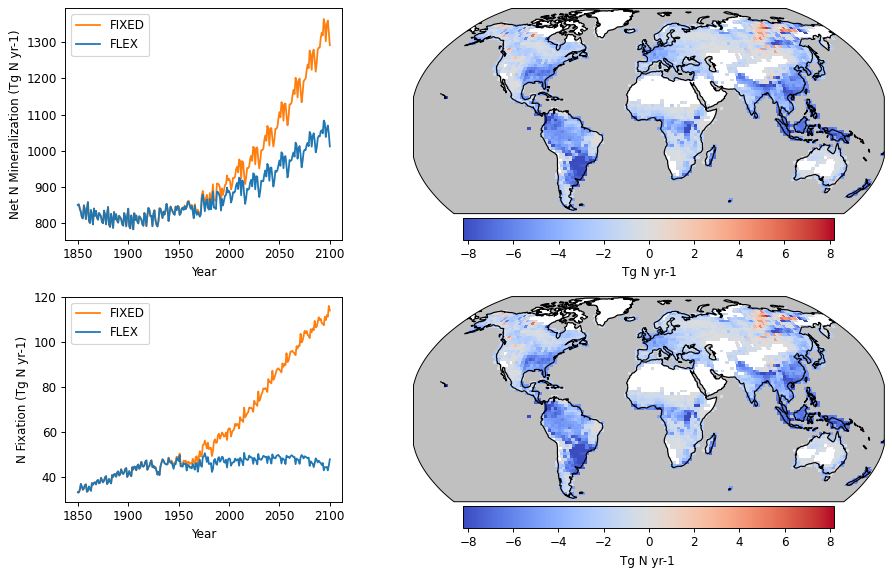

In [51]:
proj = ccrs.Robinson(central_longitude=0)
z = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['NET_NMIN']# Climatology for last 10 years of data
zMulti = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['NET_NMIN']
zdiff = zMulti - z
zdiff = utils.cyclic_dataarray(zdiff)
lat = zdiff.coords['lat']
lon = zdiff.coords['lon']

fig = plt.figure(figsize=(14, 8), dpi=86)
spec = fig.add_gridspec(20, 40)

ax2 = fig.add_subplot(spec[0:8, 10:40], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Change in N Mineralization')
im = zdiff.plot(x='lon', y='lat',
                  #vmin=-7, vmax=7,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax = fig.add_subplot(spec[8:9, 17:33])
cb1 = fig.colorbar(im, cax=cax, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax.set_title("Tg N yr-1", y=-2, fontsize = 10)
cax.xaxis.set_ticks_position('bottom')

ax1 = fig.add_subplot(spec[0:9, :12])
NPP1 = ann_glob_sub.isel(case = 1)
NPP1.attrs['NET_NMIN'] = ann_glob.get('NET_NMIN').attrs
NPP0 = ann_glob_sub.isel(case = 0)
NPP0.attrs['NET_NMIN'] = ann_glob.get('NET_NMIN').attrs

ax1.plot(ann_Awgt_sub.coords['time.year'], NPP0.get('NET_NMIN'), label = "FIXED", color = "#ff7f0e");
ax1.plot(ann_Awgt_sub.coords['time.year'], NPP1.get('NET_NMIN'), label = "FLEX", color = "#1f77b4");
ax1.set_xlabel('Year')
ax1.set_ylabel('Net N Mineralization (Tg N yr-1)')
ax1.set_title('');
ax1.legend(loc='upper left');

###############Start NFIX set 
z2 = dsAnn.isel(case=0,time=slice(-10,None)).mean('time')['NFIX']# Climatology for last 10 years of data
zMulti2 = dsAnn.isel(case=1,time=slice(-10,None)).mean('time')['NFIX']
zdiff2 = zMulti2 - z2
zdiff2 = utils.cyclic_dataarray(zdiff)

ax2 = fig.add_subplot(spec[11:19, 10:40], projection=proj)
ax2.add_feature(cfeature.OCEAN, facecolor='silver')
ax2.coastlines()
ax2.set_extent((-180, 180, -58, 85), crs=ccrs.PlateCarree())
#ax2.set_title('Change in N Fixation')
im = zdiff2.plot(x='lon', y='lat',
                  #vmin=0, vmax=2000,
                  cmap='coolwarm',
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False, robust = True)
cax3 = fig.add_subplot(spec[-1:,17:33])
cb3 = fig.colorbar(im, cax=cax3, orientation="horizontal")#,shrink = 0.5, pad=0.02, fraction = 0.05)
cax3.set_title("Tg N yr-1 ", y=-2, fontsize = 10)
cax3.xaxis.set_ticks_position('bottom')

ax1 = fig.add_subplot(spec[11:19, :12])
NFIX1 = ann_glob_sub.isel(case = 1)
NFIX1.attrs['NFIX'] = ann_glob.get('NFIX').attrs
NFIX0 = ann_glob_sub.isel(case = 0)
NFIX0.attrs['NFIX'] = ann_glob.get('NFIX').attrs

ax1.plot(ann_glob_sub.coords['time.year'], NFIX0.get('NFIX'), label = "FIXED", color = "#ff7f0e");
ax1.plot(ann_glob_sub.coords['time.year'], NFIX1.get('NFIX'), label = "FLEX", color = "#1f77b4");
ax1.set_xlabel('Year')
ax1.set_ylabel('N Fixation (Tg N yr-1)')
ax1.set_title('');
ax1.legend(loc='upper left');